## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sn
import scipy.stats as stats

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

In [2]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Importing dataset

In [3]:
card = pd.read_excel("C:/Users/HP/Downloads/1. Predicting Credit Card Spend & Identifying Key Drivers/Data Set.xlsx")

In [4]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


## Defining UDFs

In [5]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [7]:
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    elif (x.dtypes == 'object'):
        x = x.fillna(x.mode())
    return x

In [8]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

## Merging the sales columns for a single Y variable`

In [9]:
card['totalspend'] = card['cardspent'] + card['card2spent']

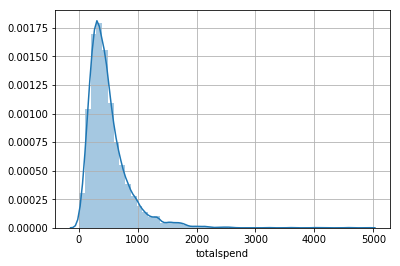

In [10]:
#checking if the Y variable is normally distributes or not

sns.distplot(card.totalspend)
plt.show()

Y variable is not normaly distributed so taking its log to make it normally distributed

In [11]:
card['ln_spend'] = np.log(card['totalspend'])

In [12]:
card['ln_spend'] = card['ln_spend'].astype('int64')

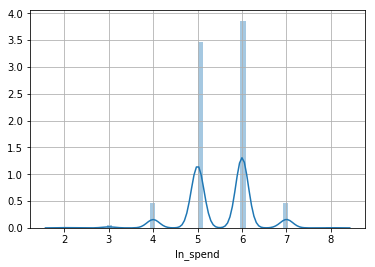

In [13]:
sns.distplot(card['ln_spend'])
plt.show()

now it is normally distributed

In [14]:
#dropping unnecessary variables

card.drop(["cardspent" , "card2spent" , "custid"] , axis=1 , inplace=True)

## converting all categorical values according to data dictionary into 'object' type

In [15]:
for x in ['region','townsize','gender','agecat','edcat','birthmonth','jobcat','union','employ','empcat','retire',
          'inccat','default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar',
          'commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
         'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat',
         'active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid',
         'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax',
        'news','response_01','response_02','response_03']:
    card[x]=card[x].astype('object')

## differentiating categorical and numerical variables into two different dataframes and checking their summaries

In [16]:
cat_var = card.select_dtypes('object')

In [17]:
num_var = card.select_dtypes(['float64', 'int64', 'float32', 'int32'])

In [18]:
num_summ = num_var.apply(continuous_var_summary)

In [19]:
num_summ

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,totalspend,ln_spend
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4999.000000,5000.000000,4999.000000,5000.000000,...,3581.000000,4.998000e+03,3578.000000,5000.000000,1344.000000,5.000000e+03,1344.000000,5000.000000,5.000000e+03,5000.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1419.000000,2.000000e+00,1422.000000,0.000000,3656.000000,0.000000e+00,3656.000000,0.000000,0.000000e+00,0.000000
SUM,235128.000000,72715.000000,273798.000000,18499.546992,49770.800000,9286.628229,-652.137155,18272.300771,3483.879384,30564.000000,...,10419.752778,3.600951e+06,22993.332638,53505.950000,4845.120915,2.109923e+06,9150.129457,98225.000000,2.490393e+06,27529.000000
MEAN,47.025600,14.543000,54.759600,3.699909,9.954160,1.857326,-0.130454,3.654460,0.696915,6.112800,...,2.909733,7.204784e+02,6.426309,10.701190,3.605001,4.219846e+02,6.808132,19.645000,4.980786e+02,5.505800
MEDIAN,47.000000,14.000000,38.000000,3.637586,8.800000,0.926437,-0.076106,2.098540,0.741537,-1.000000,...,2.904165,4.250000e+02,6.639876,0.000000,3.597997,0.000000e+00,7.147185,20.000000,4.142500e+02,6.000000
STD,17.770338,3.281083,55.377511,0.747072,6.399783,3.415732,1.273058,5.395172,1.128578,7.743518,...,0.564859,9.222255e+02,1.172050,19.799837,0.390102,1.001003e+03,1.283967,5.165609,3.515293e+02,0.734080
VAR,315.784902,10.765504,3066.668742,0.558116,40.957226,11.667225,1.620678,29.107876,1.273689,59.962069,...,0.319066,8.504999e+05,1.373700,392.033527,0.152179,1.002008e+06,1.648571,26.683512,1.235728e+05,0.538874
MIN,18.000000,6.000000,9.000000,2.197225,0.000000,0.000000,-6.597334,0.000000,-4.092107,-1.000000,...,1.178655,0.000000e+00,1.558145,0.000000,2.541602,0.000000e+00,2.541602,0.000000,8.110000e+00,2.000000
P1,18.000000,8.000000,9.000000,2.197225,0.700000,0.033160,-3.401690,0.114299,-2.168241,-1.000000,...,1.658228,0.000000e+00,2.484907,0.000000,2.806811,0.000000e+00,3.039749,0.000000,5.819760e+01,4.000000
P5,20.000000,9.000000,13.000000,2.564949,1.900000,0.101088,-2.291604,0.287692,-1.243483,-1.000000,...,1.981001,0.000000e+00,4.094345,0.000000,2.992964,0.000000e+00,4.114134,12.000000,1.331060e+02,4.000000


In [20]:
cat_summ = cat_var.apply(categorical_var_summary)

In [21]:
cat_summ

,region,townsize,gender,agecat,birthmonth,edcat,jobcat,union,employ,empcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
N,5000.00,4998.00,5000.00,5000.00,5000,5000.00,5000.0,5000.00,5000.00,5000.0,...,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
NMISS,0.00,2.00,0.00,0.00,0,0.00,0.0,0.00,0.00,0.0,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MODE,5.00,1.00,1.00,4.00,September,2.00,2.0,0.00,0.00,2.0,...,1.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FREQ,1027.00,1436.00,2518.00,1222.00,458,1567.00,1640.0,4244.00,659.00,1180.0,...,4664.00,3995.0,3164.00,2604.00,2626.00,4106.00,2637.00,4582.00,4351.00,4487.00
PERCENT,20.54,28.73,50.36,24.44,9.16,31.34,32.8,84.88,13.18,23.6,...,93.28,79.9,63.28,52.08,52.52,82.12,52.74,91.64,87.02,89.74


## Treating Outliers

In [22]:
num_var = num_var.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

## Missing values treatment

In [23]:
cat_var = cat_var.apply(missing_imputation)
num_var = num_var.apply(missing_imputation)

In [24]:
for c_feature in cat_var.columns:
    cat_var[c_feature] = cat_var[c_feature].astype('category')
    cat_var = create_dummies(cat_var , c_feature)

## merging the datasets and making one final data

In [25]:
card_new = pd.concat([num_var , cat_var] , axis=1)

In [26]:
#dropping log variables

card_new.drop(['cardten', 'lninc','lncreddebt','lnothdebt','lnlongmon','lnlongten','lntollmon','lntollten',
'lnequipmon','lnequipten','lncardten','lnwiremon','lnwireten'],axis=1, inplace=True)

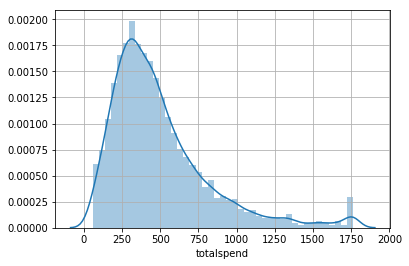

In [27]:
sns.distplot(card_new.totalspend)  #not normally distributed

In [28]:
card_new['ln_totalspend'] = np.log(card_new['totalspend'])

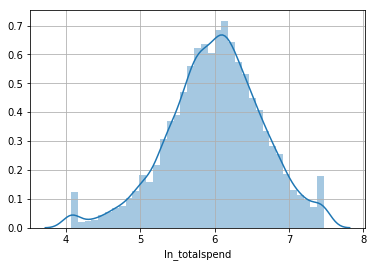

In [29]:
sns.distplot(card_new.ln_totalspend)  #noramlly distributed

In [30]:
card_new.drop(['totalspend'] , axis = 1 , inplace = True)

## heatmap to check multi colinearity

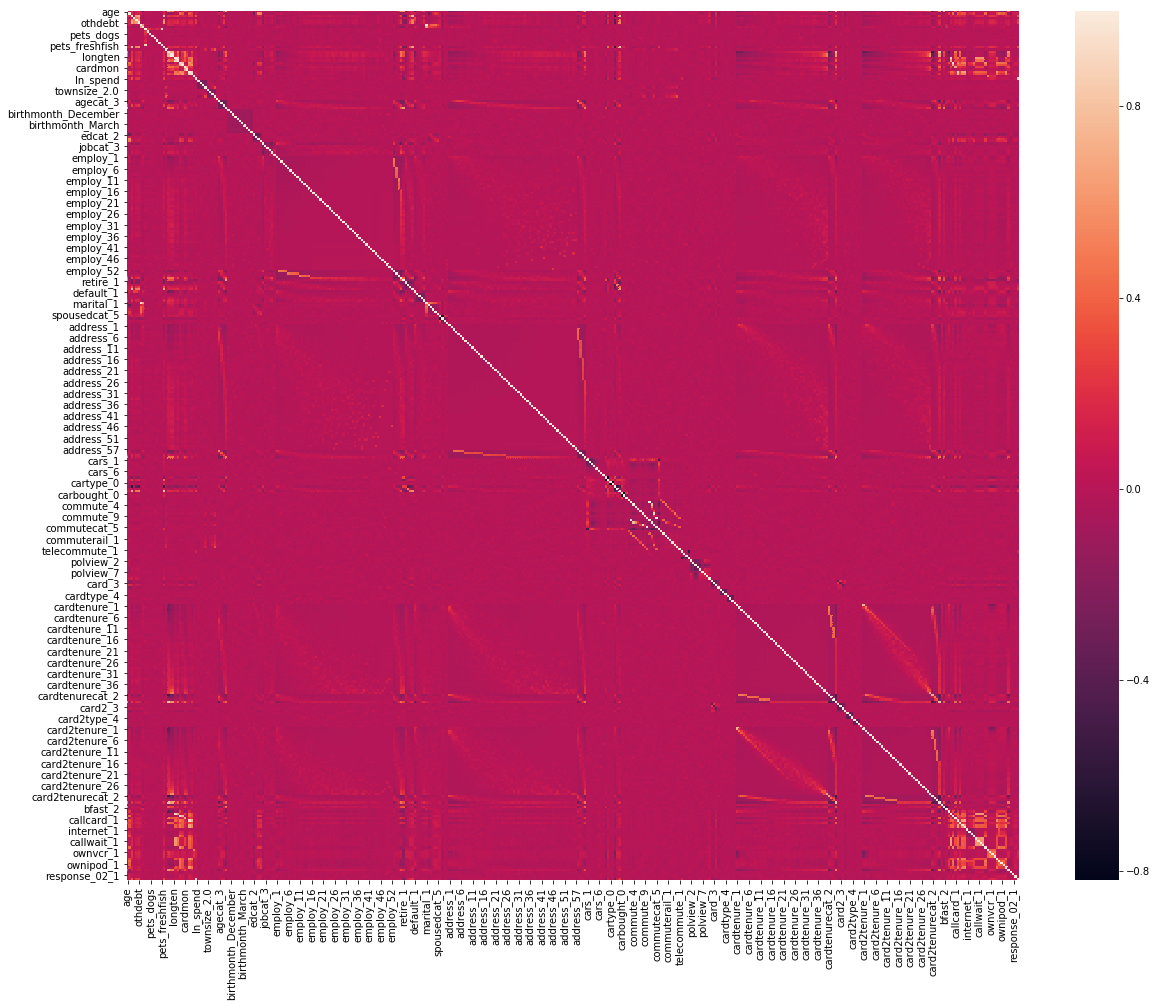

In [62]:
plt.figure(figsize = (20, 16))
sns.heatmap(card_new.corr())

## selecting feature columns manually on the basis of heatmap

In [38]:
feature_columns2 = ['income', 'card_3', 'card_2', 'carvalue', 'card_4', 
                                                'commutetime', 'reason_2', 'debtinc', 'hourstv', 'creddebt', 'age', 
                                                'tenure', 'ed', 'othdebt', 'pets', 
                                                'cardmon', 'card_5', 
                                                'reside', 'spoused', 
                                                'tollten', 'longten', 'card2_2', 'card2_3', 
                                                'equipten', 'wireten', 
                                                'equipmon', 'wiremon', 'jobsat_4', 'commutebus_1', 'card2benefit_4']

In [39]:
#spliting into train & test

train, test = train_test_split(card_new, test_size = 0.3, random_state = 12345)

In [40]:
#trying the model

model_param = 'ln_totalspend ~ ' + ' + '.join(feature_columns2)

In [41]:
lm = smf.ols(model_param, train).fit()

In [42]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_totalspend   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     45.93
Date:                Thu, 14 May 2020   Prob (F-statistic):          7.28e-226
Time:                        21:40:07   Log-Likelihood:                -2848.9
No. Observations:                3500   AIC:                             5760.
Df Residuals:                    3469   BIC:                             5951.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.2031      0.092     67.

## Now checking multi colinearity with VIF

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [44]:
y, X = dmatrices(model_param, train, return_type = 'dataframe')

In [45]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [46]:
vif.round(1).sort_values(by=['VIF Factor'],ascending=False)

,Features,VIF Factor
0,Intercept,99.4
25,wireten,9.2
27,wiremon,8.6
24,equipten,6.8
1,income,6.7
26,equipmon,6.7
14,othdebt,4.2
12,tenure,3.8
4,carvalue,3.3
8,debtinc,2.8


In [47]:
vif1 = vif[vif['VIF Factor'] > 8].reset_index().loc[:,['Features']]

vif1.drop([0] , axis = 0 , inplace = True)

drop_vars = vif1["Features"].tolist()

drop_vars

['wireten', 'wiremon']

In [49]:
#Now manually removing 'wireten', 'wiremon' from features

feature_columns2 = ['income', 'card_3', 'card_2', 'carvalue', 'card_4', 
                                                'commutetime', 'reason_2', 'debtinc', 'hourstv', 'creddebt', 'age', 
                                                'tenure', 'ed', 'othdebt', 'pets', 
                                                'cardmon', 'card_5', 
                                                'reside', 'spoused', 
                                                'tollten', 'longten', 'card2_2', 'card2_3', 
                                                'equipten', 'equipmon', 'jobsat_4', 'commutebus_1', 'card2benefit_4']

In [50]:
#Runnig the final model

model_param2 = 'ln_totalspend ~ ' + ' + '.join(feature_columns2)

lm2 = smf.ols(model_param, train).fit()

print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_totalspend   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     45.93
Date:                Thu, 14 May 2020   Prob (F-statistic):          7.28e-226
Time:                        21:42:18   Log-Likelihood:                -2848.9
No. Observations:                3500   AIC:                             5760.
Df Residuals:                    3469   BIC:                             5951.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.2031      0.092     67.

In [55]:
train['pred_sales'] = np.exp(lm2.predict(train))

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
test['pred_sales'] = np.exp(lm2.predict(test))

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
test_pred=lm.predict(test_x)
train_pred=lm.predict(train_x)

from sklearn import metrics

print('MSE Test:',metrics.mean_squared_error(test_y,test_pred))
print('MSE Train:',metrics.mean_squared_error(train_y,train_pred))

MSE Test: 0.31384081574120964
MSE Train: 0.2982179970412333


In [61]:
print ('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print ('MSE:', metrics.mean_squared_error(test_y, test_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 0.4431829136692271
MSE: 0.31384081574120964
RMSE: 0.560214972792775
